# Explore here

## Step 1: Problem statement and data collection¶

# The database is about diabetes, the main column is a binary column, with 0 for no diabetes, 1 for pre diabetes or diabetes, the rest is mostly health data about the patient and some non related information or so would it seem.
# First we will load the data, create the test and train, and then delete duplicates

In [26]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
file_path = '/workspaces/BakuDShaggy-EDA-mas-proyecto-final/data/raw/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# 1. Verify 50/50 balance
print("Class Balance:")
print(data['Diabetes_binary'].value_counts(normalize=True))

# 2. Check missing values
print("\nMissing Values:", data.isnull().sum().sum())

# 3. Confirm binary features
binary_cols = [col for col in data.columns 
               if sorted(data[col].unique()) in [[0,1], [0.0,1.0]]]

print(f"\nBinary Features: {len(binary_cols)}/21 (BMI is continuous)")

print(f"Full dataset shape:{data.shape}")

Class Balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

Missing Values: 0

Binary Features: 15/21 (BMI is continuous)
Full dataset shape:(70692, 22)


In [27]:
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 80% train, 20% test
    random_state=42,
    stratify=y 
)
train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train

test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

print(f"\nTrain shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")


Train shape: (56553, 22)
Test shape: (14139, 22)


In [29]:
# PhysHlth Binning
bins = [0, 7, 14, 30]
labels = ['0-7_days', '8-14_days', '15-30_days']

# Apply to both train and test sets
for dataset in [X_train, X_test]:
    dataset['PhysHlth_grouped'] = pd.cut(dataset['PhysHlth'], 
                                        bins=bins, 
                                        labels=labels)
    dataset.drop('PhysHlth', axis=1, inplace=True)

# Verification
print("Train Set After Binning:")
print(X_train['PhysHlth_grouped'].value_counts())
print("\nTest Set After Binning:")
print(X_test['PhysHlth_grouped'].value_counts())

Train Set After Binning:
PhysHlth_grouped
0-7_days      11930
15-30_days     9968
8-14_days      2666
Name: count, dtype: int64

Test Set After Binning:
PhysHlth_grouped
0-7_days      2944
15-30_days    2569
8-14_days      700
Name: count, dtype: int64


In [30]:
# Check first few rows
print("\nFirst 3 rows of training data:")
print(train_data.head(3))

# Basic info
print("\nData types:")
print(train_data.dtypes)

# Check class balance
print("\nClass distribution:")
print(train_data['Diabetes_binary'].value_counts(normalize=True))

# Basic statistics
print("\nDescriptive statistics:")
print(train_data.describe())


First 3 rows of training data:
       HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
47977     1.0       0.0        1.0  29.0     1.0     0.0   
2676      0.0       1.0        1.0  24.0     1.0     0.0   
35637     1.0       0.0        1.0  42.0     1.0     0.0   

       HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  NoDocbcCost  \
47977                   0.0           1.0     1.0      1.0  ...          0.0   
2676                    0.0           1.0     0.0      1.0  ...          0.0   
35637                   0.0           1.0     1.0      1.0  ...          0.0   

       GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  \
47977      2.0       0.0       0.0       0.0  1.0  10.0        6.0     8.0   
2676       3.0      15.0       6.0       0.0  0.0   7.0        5.0     1.0   
35637      3.0       0.0      10.0       1.0  0.0  11.0        5.0     4.0   

       Diabetes_binary  
47977              1.0  
2676               0.0  
35637             

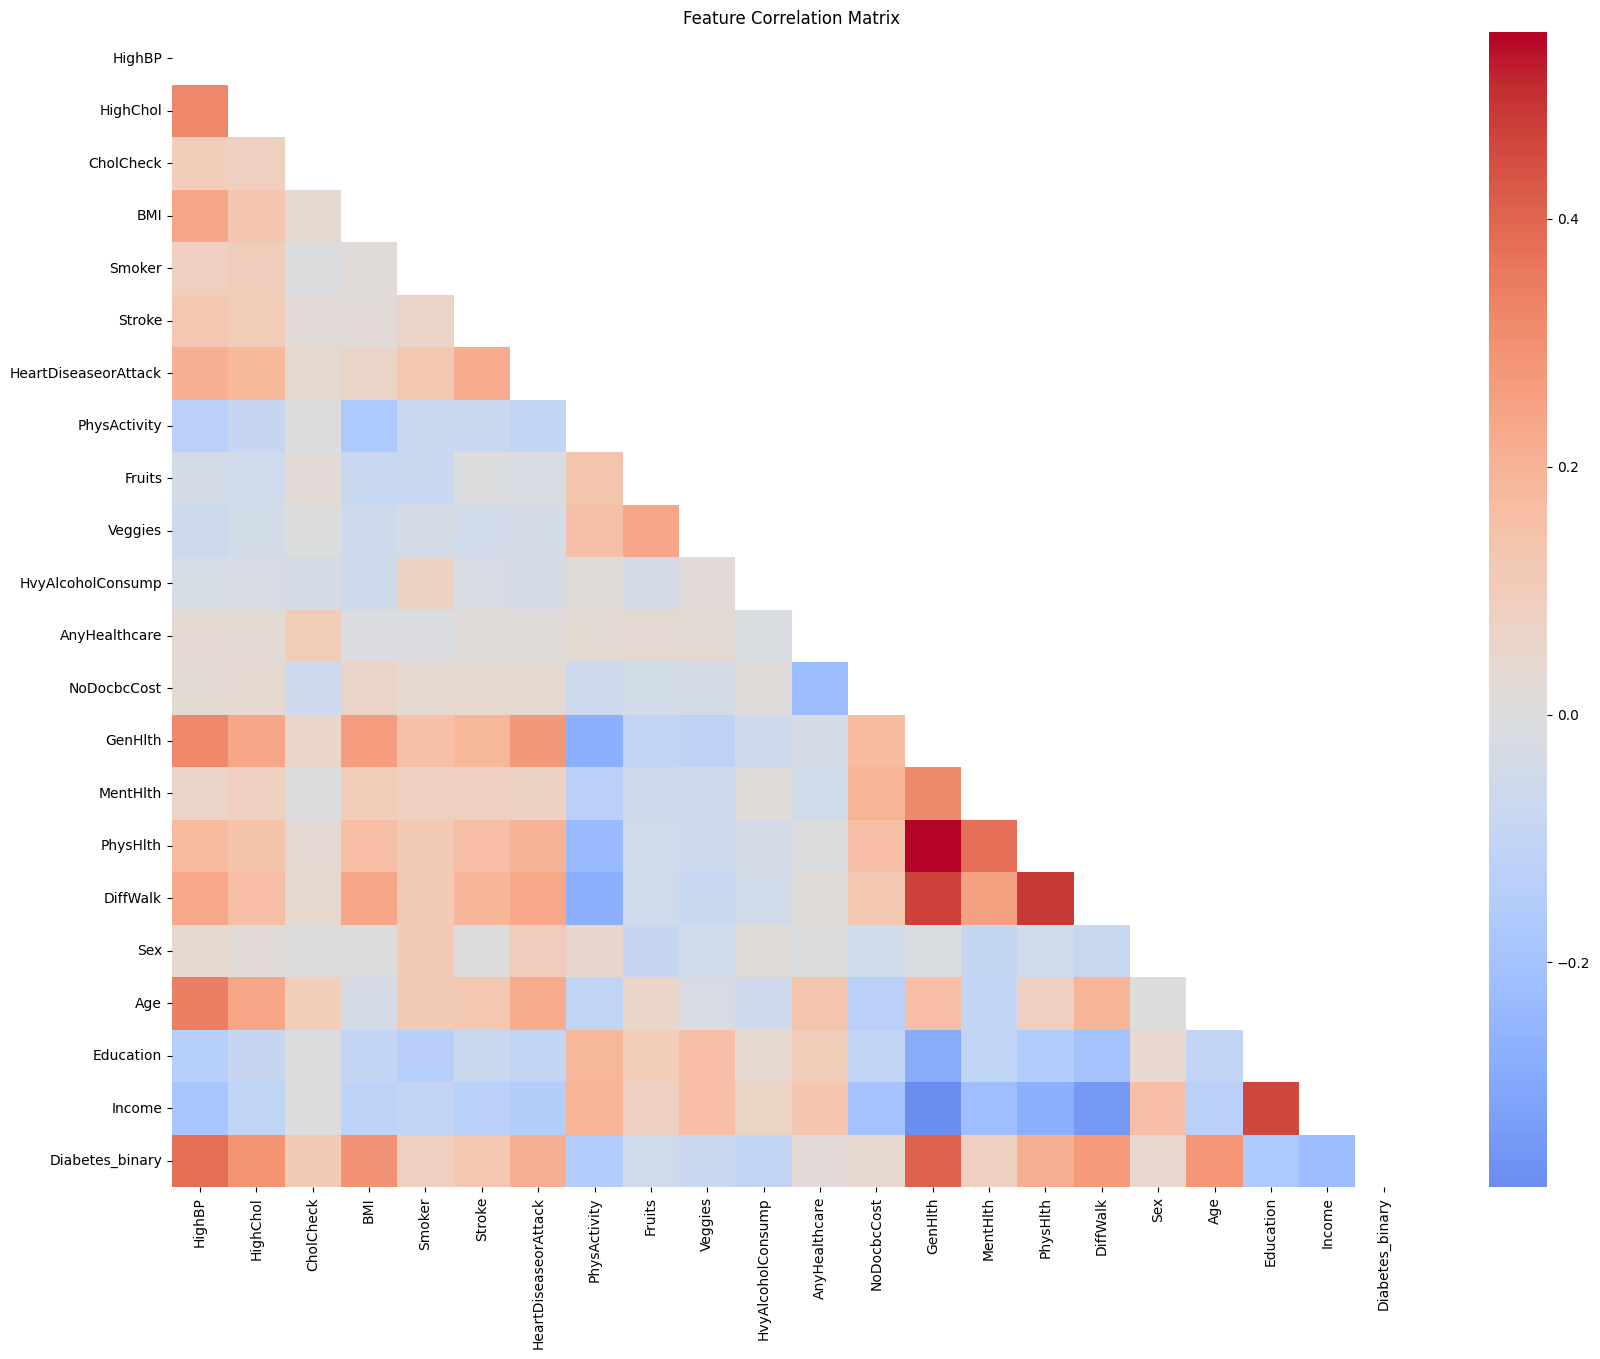

In [31]:
plt.figure(figsize=(20,15))
corr_matrix = train_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()


In [32]:
print("\nMissing values in training set:")
print(train_data.isnull().sum().sort_values(ascending=False))

print("\nMissing values in test set:")
print(test_data.isnull().sum().sort_values(ascending=False))


Missing values in training set:
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64

Missing values in test set:
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth        

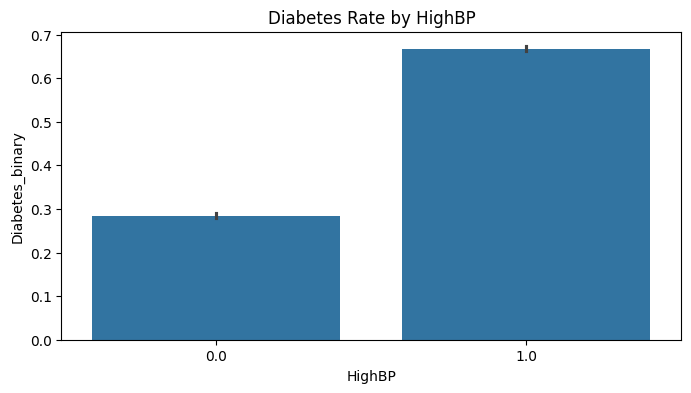

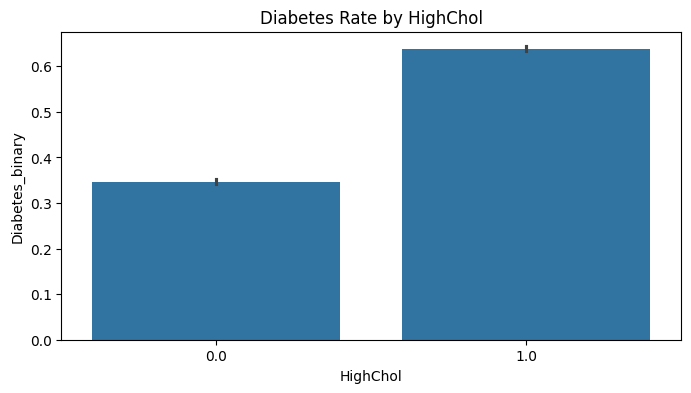

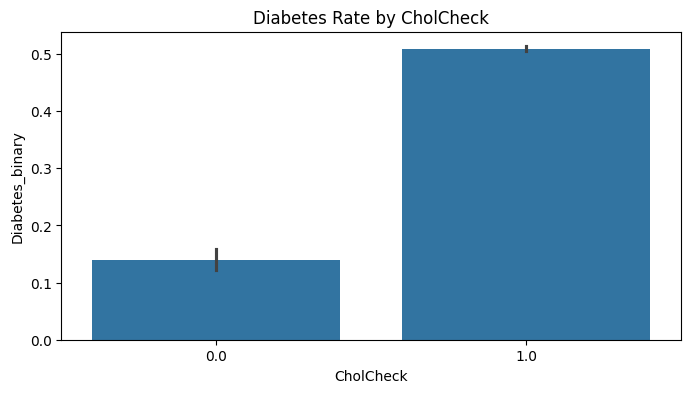

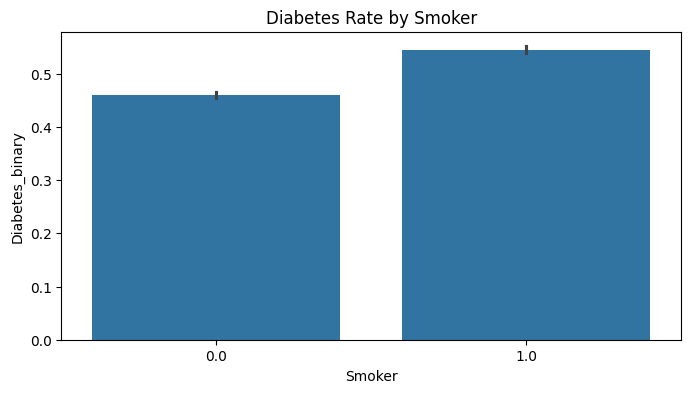

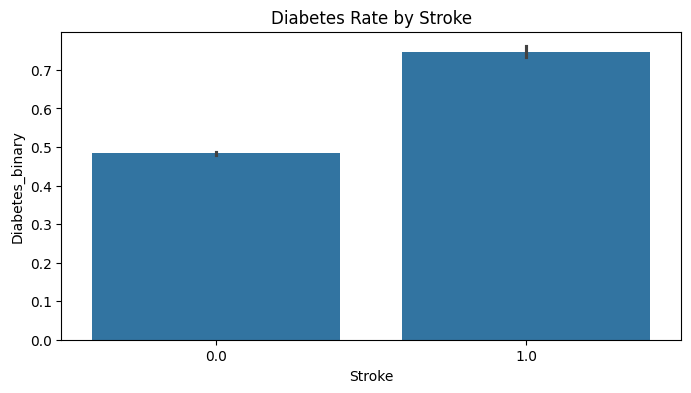

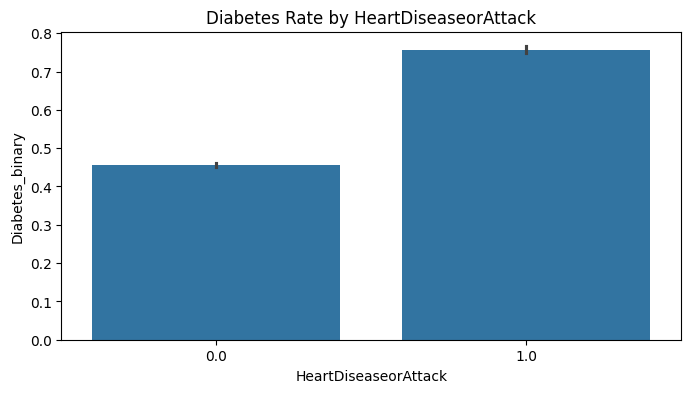

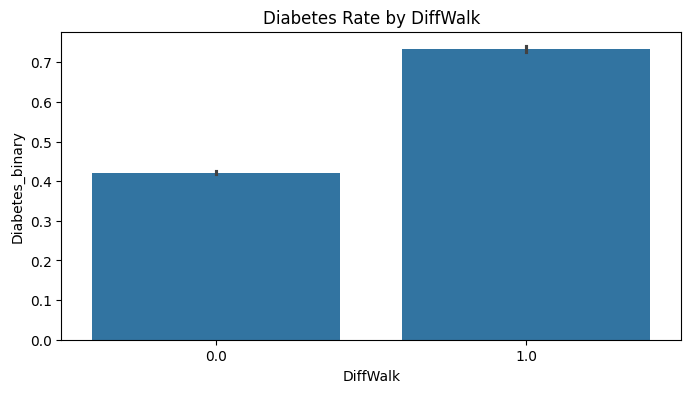

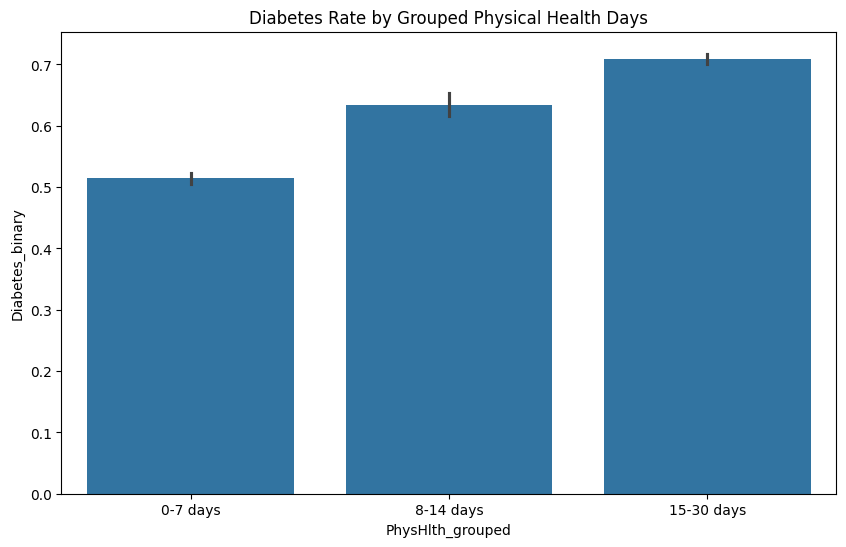

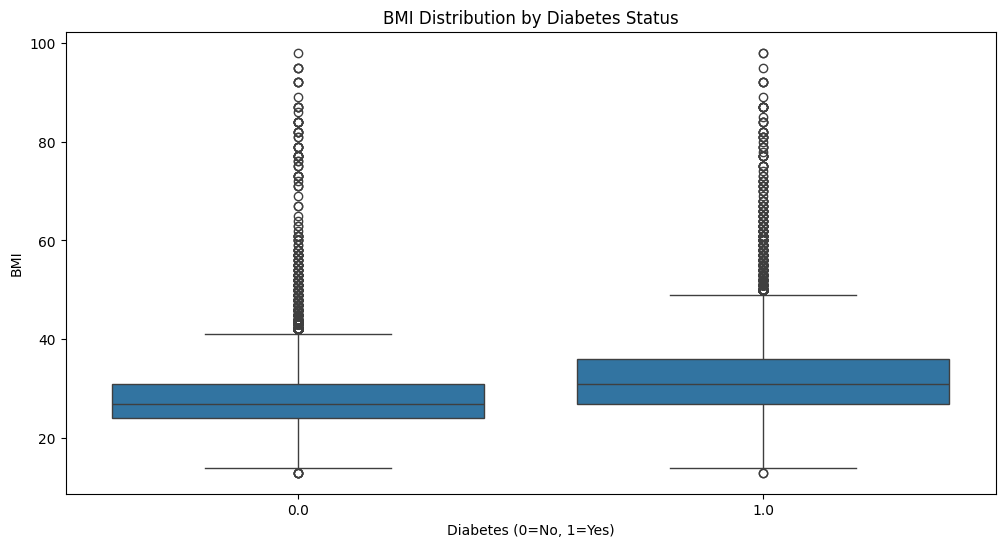

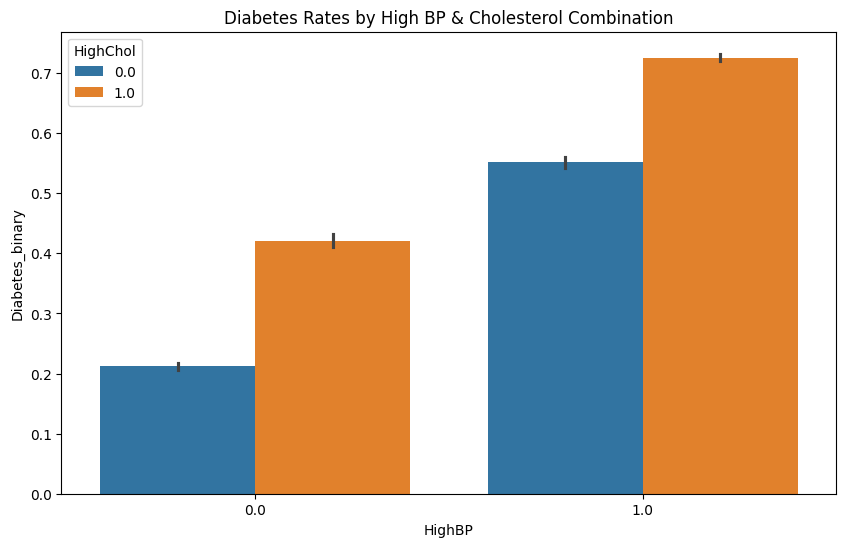

In [33]:
def plot_feature(feature):
    plt.figure(figsize=(8,4))
    sns.barplot(x=feature, y='Diabetes_binary', data=train_data)
    plt.title(f'Diabetes Rate by {feature}')
    plt.show()

plot_feature('HighBP')       
plot_feature('HighChol')     
plot_feature('CholCheck')
plot_feature('Smoker')
plot_feature('Stroke')
plot_feature('HeartDiseaseorAttack')
plot_feature('DiffWalk')
bins = [0, 7, 14, 30]
labels = ['0-7 days', '8-14 days', '15-30 days']

for df in [train_data, test_data]:
    df['PhysHlth_grouped'] = pd.cut(df['PhysHlth'], bins=bins, labels=labels)
    df.drop('PhysHlth', axis=1, inplace=True)

# Plot the grouped version
plt.figure(figsize=(10,6))
sns.barplot(x='PhysHlth_grouped', y='Diabetes_binary', data=train_data)
plt.title("Diabetes Rate by Grouped Physical Health Days")
plt.show()

# BMI Analysis
plt.figure(figsize=(12,6))
sns.boxplot(x='Diabetes_binary', y='BMI', data=train_data)
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("Diabetes (0=No, 1=Yes)")
plt.show()

# Feature Interaction
plt.figure(figsize=(10,6))
sns.barplot(x='HighBP', y='Diabetes_binary', hue='HighChol', data=train_data)
plt.title("Diabetes Rates by High BP & Cholesterol Combination")
plt.show()
